In [ ]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision.datasets import ImageFolder

## Custom Neural Net

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d()
    self.pool = nn.MaxPool2d()
    self.conv2 = nn.Conv2d()
    self.conv3 = nn.Conv2d()
    self.fc1 = nn.Linear()
    
  def forward(self, x):

    c1 = F.relu(self.conv1(x))
    p1 = self.pool(c1)
    c2 = F.relu(self.conv2(p1))
    p2 = self.pool(c2)
    c3 = F.relu(self.conv3(p2))
    c3 = torch.flatten(c3, 1)
    z = self.fc1(c3)

    return z

# Freeze Layers

In [ ]:
def freeze_layers(model, num_layers=18):
  idx = 0
  for name, param in model.named_parameters():
    if idx >= num_layers*2:
      break
    param.requires_grad_(False)
    idx += 1

# Helper Functions

In [ ]:
# Accuracy Metric
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

# For Validation step
def eval(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def predict(input, model):
  preds = model(torch.unsqueeze(input, 0))
  return preds[torch.argmax(preds)]

# Fit Function

In [ ]:
def fit(epochs, model, train_loader, val_loader, optimizer):
  results = []
  for epoch in range(epochs):
    print(epoch)
    # Training Phase 
    model.train()
    t_losses = []
    print("training")
    for batch in train_loader:
      image, labels = batch
      out = model(image)
      loss = F.cross_entropy(out, labels)
      t_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    print("validating")
    result = eval(model, val_loader)
    result['train_loss'] = torch.stack(t_losses).mean().item()
    model.epoch_end(epoch, result)
    torch.save (model.state_dict(), f"model_ckpt{epoch}.pt")
    results.append(result)
  return results

# Plot Functions

In [ ]:
# Plot accuracy
def plot_accuracies(results):
  accuracies = [x['val_acc'] for x in results]  
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

# Plot Loss
def plot_losses(results):
  train_losses = [x.get('train_loss') for x in results]
  val_losses = [x['val_loss'] for x in results]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Base Class to Help with Validation

In [ ]:
class MultiClassImageClassification(nn.Module):
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    
    loss = F.cross_entropy(out, labels)   
    acc = accuracy(out, labels)           
    return {'val_loss': loss.detach(), 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
      epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Main Function

1
2
3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


4


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

5
0
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0], train_loss: 2.2684, val_loss: 1.5416, val_acc: 0.5965
1
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expe

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1], train_loss: 1.5693, val_loss: 1.2918, val_acc: 0.6535
2
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2], train_loss: 1.3675, val_loss: 1.3114, val_acc: 0.6385
3
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3], train_loss: 1.2882, val_loss: 1.3060, val_acc: 0.6777
4
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4], train_loss: 1.2442, val_loss: 1.2302, val_acc: 0.6768
5
training


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5], train_loss: 1.2274, val_loss: 1.1892, val_acc: 0.6899
6
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6], train_loss: 1.2565, val_loss: 1.1681, val_acc: 0.6881
7
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7], train_loss: 1.2258, val_loss: 1.2169, val_acc: 0.6707
8
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8], train_loss: 1.1986, val_loss: 1.1504, val_acc: 0.6916
9
training


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

validating


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9], train_loss: 1.0980, val_loss: 1.1101, val_acc: 0.6917


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Final val: 
{'val_loss': 1.1100653409957886, 'val_acc': 0.691721498966217}


TypeError: ignored

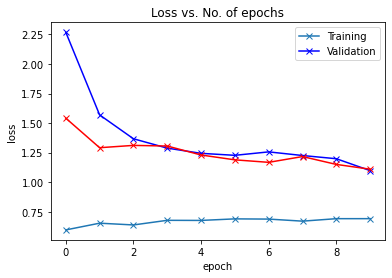

In [ ]:
def main():
  print("1")
  np.random.seed(442)
  torch.manual_seed(442)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Format Data
  print("2")

  transform_image = {
    "train": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]),
    "test": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
  }


  # Data loading
  print("3")

  train_data = ImageFolder('/content/drive/MyDrive/Dataset/train', transform=transform_image["train"])
  test_data = ImageFolder('/content/drive/MyDrive/Dataset/test', transform=transform_image["test"])
  val_data = ImageFolder('/content/drive/MyDrive/Dataset/validation', transform=transform_image["test"])

  batch_size = 128
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

  # classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
  classes = [

  ]

  # Network and Transfer Learning

  print("4")

  resnet = models.resnet18(pretrained=True)

  # layers_to_freeze = 
  freeze_layers(resnet)

  resnet = nn.Sequential(
      resnet,
      nn.Linear(in_features=1000, out_features=36),
      nn.ReLU()
  )

  class BetterNet(MultiClassImageClassification):
    def __init__(self):
      super().__init__()
      self.net = resnet
        
    def forward(self, xb):
      return self.net(xb)

  model = BetterNet()

  # Train

  print("5")
    
  num_epochs = 10
  learning_rate = 0.001

  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

  results = fit(num_epochs, model, train_loader, val_loader, optimizer)

  val = eval(model, val_loader)

  print("Final val: ")
  print(val)

  # Plots

  plot_accuracies(results)

  plot_losses(results)

  # Predict

  for i, img in enumerate(test_data):
    prediction = predict(img[0], model)
    print(classes[prediction])
    
  # Done


if __name__=="__main__":
    main()

## Plot accuracy

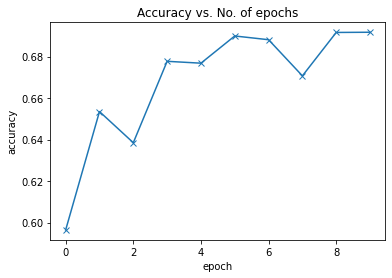

In [ ]:
def plot_accuracies():
  accuracies = [0.5965, 0.6535, 0.6385, 0.6777, 0.6768, 0.6899, 0.6881, 0.6707, 0.6916, 0.6917]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

plot_accuracies()

## Plot Loss

In [ ]:
def plot_losses():
  train_losses = [2.2684, 1.5693, 1.3675]
  val_losses = [1.5416, 1.2918, 1.3114, ]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

plot_losses()

In [ ]:
transform_image = {
    "train": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ]),
    "test": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
  }

test_data = ImageFolder('/content/drive/MyDrive/Dataset/test', transform=transform_image["test"])

resnet = models.resnet18(pretrained=True)

freeze_layers(resnet)

resnet = nn.Sequential(
    resnet,
    nn.Linear(in_features=1000, out_features=36),
    nn.ReLU()
)

classes = [
            "apple",
            "turnip",
            "chillipepper",
            "raddish",
            "bellpepper",
            "pear",
            "sweetpotato",
            "pomegranate",
            "peas",
            "capsicum",
            "spinach",
            "lettuce",
            "kiwi",
            "lemon",
            "onion",
            "cauliflower",
            "potato",
            "jalepeno",
            "sweetcorn",
            "cucumber",
            "watermelon",
            "mango",
            "cabbage",
            "grapes",
            "beetroot",
            "eggplant",
            "corn",
            "soybeans",
            "banana",
            "ginger",
            "garlic",
            "pineapple",
            "tomato",
            "orange",
            "carrot"
]

class BetterNet(MultiClassImageClassification):
    def __init__(self):
      super().__init__()
      self.net = resnet
        
    def forward(self, xb):
      return self.net(xb)

model = BetterNet()

model.load_state_dict (torch.load("./model_ckpt9.pt"))

# print(model.parameters())

for i, img in enumerate(test_data):
    prediction = predict(img[0], model)
    # print(prediction)
    print(classes[torch.argmax(prediction)])